In [7]:
import os

In [28]:
path = "/home/saeed/Walnut/AdvancedLiterateMachinery/DocumentUnderstanding/VGT/mini/pickle_files/A_2003_page_19_table_0.pkl"
weights = "/home/saeed/Walnut/AdvancedLiterateMachinery/DocumentUnderstanding/VGT/publaynet_VGT_model.pth"
png_root_dir = "/home/saeed/DocLayNet_core/PNG/000000c264503f54eea3adfd8fabafe47248c76f7d688cb8f26b4d24876fccbe.png"


In [29]:
from PIL import Image
image = Image.open(png_root_dir)

In [30]:
import pickle

In [31]:
grid_info = pickle.load(open(path, "rb"))

In [32]:
len(grid_info["bbox_texts_list"])

36

In [33]:
len(grid_info["texts"])

36

In [34]:
len(grid_info["bbox_subword_list"])

72

In [35]:
len(grid_info["input_ids"])

72

In [27]:
import matplotlib.pyplot as plt
def plot_bounding_boxes(image,anno, figsize=(10, 10)):
    colors = {'table row':'b', 'table':'g', 'table column':'r','table spanning cell':'c','table projected row header':'m','table column header':'y'}
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    for ann in anno:
        box = ann
        rect = plt.Rectangle((box[0], box[1]), box[2], box[3], linewidth=0.5, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # label = f"{ann['label']}"
        # ax.text(box[0], box[1], label, fontsize=8, color='b')
    plt.show()

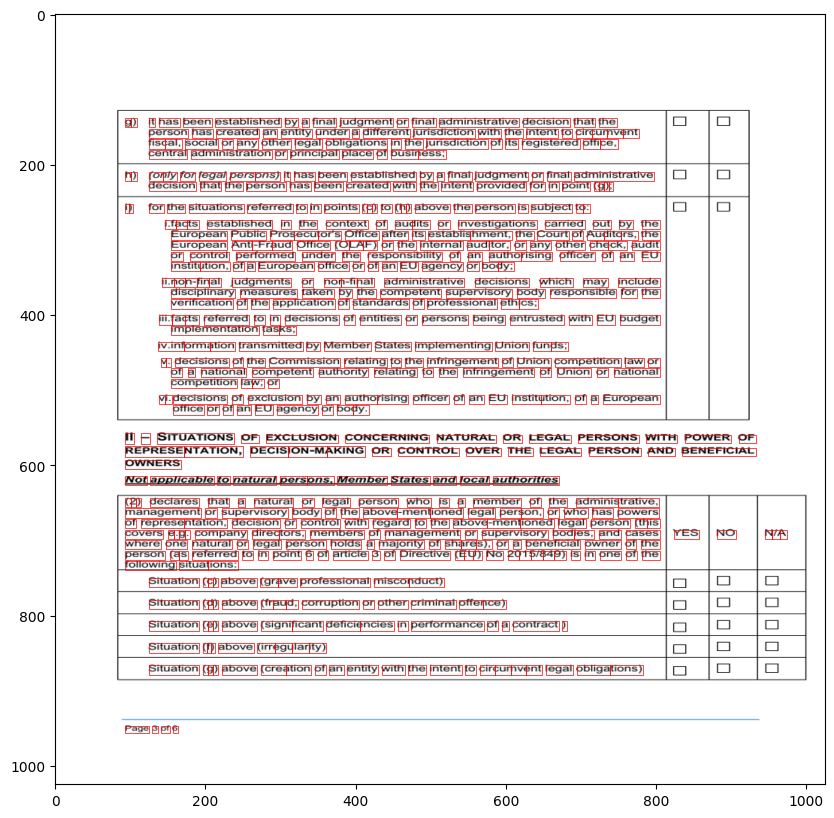

In [29]:
plot_bounding_boxes(image, grid_info["bbox_subword_list"])

In [30]:
grid_info

{'input_ids': array([ 1043,  1007,  2009,  2038,  2042,  2511,  2011,  1037,  2345,
         8689,  2030,  2345,  3831,  3247,  2008,  1996,  2711,  2038,
         2580,  2019,  9178,  2104,  1037,  2367,  7360,  2007,  1996,
         7848,  2000, 25022, 11890,  2819, 15338, 10807,  1010,  2591,
         2030,  2151,  2060,  3423, 14422,  1999,  1996,  7360,  1997,
         2049,  5068,  2436,  1010,  2430,  3447,  2030,  4054,  2173,
         1997,  2449,  1025,  1044,  1007,  1006,  2069,  2005,  3423,
         5381,  1007,  2009,  2038,  2042,  2511,  2011,  1037,  2345,
         8689,  2030,  2345,  3831,  3247,  2008,  1996,  2711,  2038,
         2042,  2580,  2007,  1996,  7848,  3024,  2005,  1999,  2391,
         1006,  1043,  1007,  1025,  1045,  1007,  2005,  1996,  8146,
         3615,  2000,  1999,  2685,  1006,  1039,  1007,  2000,  1006,
         1044,  1007,  2682,  1996,  2711,  2003,  3395,  2000,  1024,
         1045,  1012,  8866,  2511,  1999,  1996,  6123,  1997, 

In [20]:
from ditod.tokenization_bros import BrosTokenizer

In [21]:
tokenizer = BrosTokenizer.from_pretrained("naver-clova-ocr/bros-base-uncased")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'BrosTokenizer'.


In [22]:
import cv2
from ditod import add_vit_config
import torch
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer#
from detectron2.data import MetadataCatalog
from ditod.VGTTrainer import DefaultPredictor#
import argparse#
import logging#
import os
import sys#
import weakref#
from collections import OrderedDict#
from typing import Optional#
import torch#
from fvcore.nn.precise_bn import get_bn_modules#
from omegaconf import OmegaConf#
from torch.nn.parallel import DistributedDataParallel#
import numpy as np#
import detectron2.data.transforms as T
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import CfgNode, LazyConfig#
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)#
from detectron2.evaluation import (
    DatasetEvaluator,
    inference_on_dataset,
    print_csv_format,
    verify_results,
)#
from detectron2.modeling import build_model
from detectron2.solver import build_lr_scheduler, build_optimizer#
from detectron2.utils import comm#
from detectron2.utils.collect_env import collect_env_info#
from detectron2.utils.env import seed_all_rng#
from detectron2.utils.events import CommonMetricPrinter, JSONWriter, TensorboardXWriter#
from detectron2.utils.file_io import PathManager#
from detectron2.utils.logger import setup_logger#

from detectron2.engine import hooks#
from detectron2.engine.train_loop import AMPTrainer, SimpleTrainer, TrainerBase#

from ditod.VGTcheckpointer import MyDetectionCheckpointer#
from typing import Any, Dict, List, Set#
import itertools#
from detectron2.solver.build import maybe_add_gradient_clipping#
from ditod.dataset_mapper import DetrDatasetMapper##
from detectron2.evaluation import COCOEvaluator#

import pickle#
from detectron2.data import detection_utils as utils
from detectron2.structures import (
    BitMasks,
    Boxes,
    BoxMode,
    Instances,
    Keypoints,
    PolygonMasks,
    RotatedBoxes,
    polygons_to_bitmask,
)


In [16]:
from fitz_utils import ProcessedDoc
class FitzExtraction:
    def get_tokens(self, page:ProcessedDoc , scale=2):
        """
        Get the bounding boxes of all the text in the PDF file using PyMuPDF.
        Inputs:
        ________
        page: page is instance of ProcessedDoc;
        bbox: bbox are the coordinates of the table on the current page. format expected [x1,y1,x2,y2]
        padding: padding to be applied to the table bbox, format expected: [-px, -py, px, py]

        Returns:
        _________
        This function returns list of dict, containing all the words inside the table bbox. each dict will have three 
        attributes, "bbox": bbox of the word, "label": "word", "text": the actual word.
        """
        words = page.get_word_df()
        if len(words) == 0:
            print(f'File  is Scanned, No word bbox found inside page number {page}')
        word_bboxes = []
        words_ = []
        for i in range(len(words)):
            word_bboxes.append([words.iloc[i]['x0']*scale, words.iloc[i]['y0']*scale, 
                                         (words.iloc[i]['x1']-words.iloc[i]['x0'])*scale, 
                                         (words.iloc[i]['y1']-words.iloc[i]['y0'])*scale])
            words_.append(words.iloc[i]['text'])      
        return words_, word_bboxes

In [17]:
class Arguments:
    pdf_path = "/home/saeed/Walnut/AdvancedLiterateMachinery/DocumentUnderstanding/VGT/object_detection/filter/105040.pdf"
    dataset = "doclaynet"
    output_dir = "/home/saeed/Walnut/AdvancedLiterateMachinery/DocumentUnderstanding/VGT/Visualizations/"
    page_to_visualize = 1
    config_file_path = "/home/saeed/Walnut/AdvancedLiterateMachinery/DocumentUnderstanding/VGT/object_detection/Configs/cascade/doclaynet_VGT_cascade_PTM.yaml"
    model_weights_path = "/home/saeed/Walnut/AdvancedLiterateMachinery/DocumentUnderstanding/VGT/doclaynet_VGT_model.pth"
    scale = 1
args = Arguments()

In [18]:
cfg = get_cfg()
add_vit_config(cfg)
cfg.merge_from_file(args.config_file_path)
# Step 3: set device
device = "cuda" if torch.cuda.is_available() else "cpu"
cfg.MODEL.DEVICE = device
word_extractor = FitzExtraction()

In [25]:

class DefaultPredictor:
    """
    Create a simple end-to-end predictor with the given config that runs on
    single device for a single input image.

    Compared to using the model directly, this class does the following additions:

    1. Load checkpoint from `cfg.MODEL.WEIGHTS`.
    2. Always take BGR image as the input and apply conversion defined by `cfg.INPUT.FORMAT`.
    3. Apply resizing defined by `cfg.INPUT.{MIN,MAX}_SIZE_TEST`.
    4. Take one input image and produce a single output, instead of a batch.

    This is meant for simple demo purposes, so it does the above steps automatically.
    This is not meant for benchmarks or running complicated inference logic.
    If you'd like to do anything more complicated, please refer to its source code as
    examples to build and use the model manually.

    Attributes:
        metadata (Metadata): the metadata of the underlying dataset, obtained from
            cfg.DATASETS.TEST.

    Examples:
    ::
        pred = DefaultPredictor(cfg)
        inputs = cv2.imread("input.jpg")
        outputs = pred(inputs)
    """
    
    def __init__(self, cfg, model_weights_path=None):
        self.cfg = cfg.clone()  # cfg can be modified by model
        self.model = build_model(self.cfg)
        self.model.eval()
        if len(cfg.DATASETS.TEST):
            self.metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])

        checkpointer = DetectionCheckpointer(self.model)
        checkpointer.load(model_weights_path)

        self.aug = T.ResizeShortestEdge(
            [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
        )

        self.input_format = cfg.INPUT.FORMAT
        assert self.input_format in ["RGB", "BGR"], self.input_format

    def __call__(self, original_image, grid_data):
        """
        Args:
            original_image (np.ndarray): an image of shape (H, W, C) (in BGR order).

        Returns:
            predictions (dict):
                the output of the model for one image only.
                See :doc:`/tutorials/models` for details about the format.
        """
        with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
            # Apply pre-processing to image.
            
            # if self.input_format == "RGB":
            #     # whether the model expects BGR inputs or RGB
            #     import ipdb;ipdb.set_trace() 
            #     original_image = original_image[:, :, ::-1]
            
            height, width = original_image.shape[:2]
            image, transforms = T.apply_transform_gens([self.aug], original_image)
            
            # add grid    
            image_shape = image.shape[:2]  # h, w
            image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
            input_ids = grid_data["input_ids"]
            bbox_subword_list = grid_data["bbox_subword_list"]
                
            # word bbox
            bbox = []
            for bbox_per_subword in bbox_subword_list:
                text_word = {}
                text_word['bbox'] = bbox_per_subword
                text_word['bbox_mode'] = BoxMode.XYWH_ABS
                utils.transform_instance_annotations(text_word, transforms, image_shape)
                bbox.append(text_word['bbox'])
                
            dataset_dict = {}
            dataset_dict["input_ids"] = input_ids 
            dataset_dict["bbox"] = bbox
            dataset_dict["image"] = image 
            dataset_dict["height"] = height 
            dataset_dict["width"] = width 

            predictions = self.model([dataset_dict])[0]
            return predictions

In [26]:
doc = ProcessedDoc(args.pdf_path)
page = doc[args.page_to_visualize]
words, word_bboxes = word_extractor.get_tokens(page, args.scale)
page_img = page.get_opencv_img()
predictor = DefaultPredictor(cfg, args.model_weights_path)
viz_save_file = os.path.join(args.output_dir, os.path.basename(args.pdf_path).split(".")[0] + "_page_" + str(args.page_to_visualize) + ".png")
md = MetadataCatalog.get(cfg.DATASETS.TEST[0])
md.set(thing_classes=["Caption","Footnote","Formula","List-item","Page-footer", "Page-header", "Picture", "Section-header", "Table", "Text", "Title"])
grid = tokenizer.tokenize_and_split_bboxs(words, word_bboxes)

use_pretrain_weight: load model from: /home/saeed/Walnut/AdvancedLiterateMachinery/DocumentUnderstanding/VGT/layoutlm_uncased/


In [ ]:
output = predictor(page_img, grid)["instances"]
v = Visualizer(page_img[:, :, ::-1],
                md,
                scale=1.0,
                instance_mode=ColorMode.SEGMENTATION)
result = v.draw_instance_predictions(output.to("cpu"))
result_image = result.get_image()[:, :, ::-1]
cv2.imwrite(viz_save_file, result_image)

In [1]:
from dfsdf import myfunc

In [2]:
myfunc()

'Hello world'

In [20]:
import fitz
file_path = "/home/saeed/Walnut/AdvancedLiterateMachinery/DocumentUnderstanding/VGT/object_detection/filter/107035.pdf"
doc = fitz.open(file_path)
doc.select([79])

In [21]:
doc.save("abc.pdf")

In [23]:
import os
import shutil
val_images_path = "/home/saeed/Walnut/AdvancedLiterateMachinery/DocumentUnderstanding/VGT/mini/val2017"
copy_source = "/home/saeed/fintabnet_p/FinTabNet.c_Image_Table_Words_JSON"
copy_dest = "/home/saeed/Walnut/AdvancedLiterateMachinery/DocumentUnderstanding/VGT/mini/words"
pikle_save_path = "/home/saeed/Walnut/AdvancedLiterateMachinery/DocumentUnderstanding/VGT/mini/pickle_files"

In [6]:
for image in os.listdir(val_images_path):
    image_name = image.split(".")[0]
    shutil.copy(os.path.join(copy_source, image_name + "_words.json"), os.path.join(copy_dest, image_name + "_words.json"))

In [27]:
import json 
import pickle
all_words_files = os.listdir(copy_dest)
for words_file in all_words_files:
    words = json.load(open(os.path.join(copy_dest, words_file), "r"))
    words = sorted(words, key=lambda x: x['span_num'])
    words_ = [word['text'] for word in words]
    bbox = [word['bbox'] for word in words]
    grid = tokenizer.tokenize_and_split_bboxs(words_, bbox)
    file_name = words_file.split(".")[0]
    file_name = file_name[:-6] + ".pkl"
    pickle.dump(grid, open(os.path.join(pikle_save_path, file_name), "wb"))

    

In [67]:
mini_dataset_root_dir = "/home/saeed/Walnut/AdvancedLiterateMachinery/DocumentUnderstanding/VGT/small_dataset"
train_images_path = os.path.join(mini_dataset_root_dir, "train")
val_images_path = os.path.join(mini_dataset_root_dir, "val")
train_words_path = os.path.join(mini_dataset_root_dir, "word_pickles")
annotations_path = os.path.join(mini_dataset_root_dir, "annotations")
source_data_root = "/home/saeed/Walnut/AdvancedLiterateMachinery/DocumentUnderstanding/VGT/mini"
source_images_path = os.path.join(source_data_root, "val2017")
source_words_path = os.path.join(source_data_root, "pickle_files")
source_coco_file_path = "/home/saeed/Walnut/AdvancedLiterateMachinery/DocumentUnderstanding/VGT/mini/instances_val.json"

In [68]:
import random 
import json
import shutil
import os
annotations = json.load(open(source_coco_file_path, "r"))


In [69]:
new_annotations_train = {'info': annotations['info'], 'licenses': annotations['licenses'], 'categories': annotations['categories'], 'images': [], 'annotations': []}
new_annotations_val = {'info': annotations['info'], 'licenses': annotations['licenses'], 'categories': annotations['categories'], 'images': [], 'annotations': []}
max_train_images = 200
max_val_images = 10
train_images = random.sample(annotations['images'], max_train_images)
val_images = random.sample(annotations['images'], max_val_images)
for sample in train_images:
    new_annotations_train['images'].append(sample)
    new_annotations_train['annotations'].extend([ann for ann in annotations['annotations'] if ann['image_id'] == sample['id']])
    image_name = sample['file_name'].split(".")[0]
    shutil.copy(os.path.join(source_images_path, sample['file_name']), os.path.join(train_images_path, 'fintabnet_' +sample['file_name']))
    shutil.copy(os.path.join(source_words_path, image_name + ".pkl"), os.path.join(train_words_path,'fintabnet_' + image_name + ".pkl"))
    new_annotations_train['images'][-1]['file_name'] = 'fintabnet_' + sample['file_name']
for sample in val_images:
    new_annotations_val['images'].append(sample)
    new_annotations_val['annotations'].extend([ann for ann in annotations['annotations'] if ann['image_id'] == sample['id']])
    image_name = sample['file_name'].split(".")[0]
    shutil.copy(os.path.join(source_images_path,  sample['file_name']), os.path.join(val_images_path, 'fintabnet_' +sample['file_name']))
    shutil.copy(os.path.join(source_words_path, image_name + ".pkl"), os.path.join(train_words_path, 'fintabnet_' +image_name + ".pkl"))
    new_annotations_val['images'][-1]['file_name'] = 'fintabnet_' + sample['file_name']
json.dump(new_annotations_train, open(os.path.join(annotations_path, "instances_train.json"), "w"))
json.dump(new_annotations_val, open(os.path.join(annotations_path, "instances_val.json"), "w"))

In [45]:
annotations.keys()

dict_keys(['info', 'categories', 'licenses', 'images', 'annotations'])

In [73]:
a = "/D4LA_root_path/D4LA/json/test.json"
a.split("/")[:-2]

['', 'D4LA_root_path', 'D4LA']

In [76]:
from detectron2.data.datasets import register_coco_instances, load_coco_json
# register_coco_instances(
#     "publaynet_train",
#     {},
#     "/publaynet_root_path/publaynet/train.json",
#     "/publaynet_root_path/publaynet/train"
# )

In [77]:
load_coco_json(dataset_name='publaynet_train')

TypeError: load_coco_json() missing 2 required positional arguments: 'json_file' and 'image_root'